# Data analysis with Neo4j and python for RESIDE_IN data

## Imports

In [1]:
from py2neo import Graph, Database , NodeMatcher, RelationshipMatcher

In [2]:
from neo4j import GraphDatabase

In [3]:
from tabulate import tabulate

In [112]:
import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib.ticker as ticker

In [5]:
%matplotlib inline

## Conect to database:

In [6]:
uri = 'bolt://neo4j-hdx:7687'

## Py2neo

In [7]:
default_db = Database(uri, auth=("neo4j", "test"))

In [8]:
default_db.name

'graphHDX.db'

Default graph in the database:

In [9]:
default_db.default_graph.name

'data'

Instanciate a Graph object conecting to the default graph 'data' exposed in 'graphHDX.db':

In [10]:
graph = Graph(uri, auth=("neo4j", "test"))

In [11]:
graph.database.name

'graphHDX.db'

Get the number of nodes in the graph:

In [12]:
len(graph.nodes)

7376

Get the number of relationship in the graph:

In [13]:
len(graph.relationships)

124501

Explore the Schema of the graph:

 - Nodes

In [14]:
graph.schema.node_labels

frozenset({'Country', 'CountryYear'})

 - Relationships

In [160]:
rel_types = graph.schema.relationship_types

In [162]:
rel_types

frozenset({'1960',
           '1961',
           '1962',
           '1963',
           '1964',
           '1965',
           '1966',
           '1967',
           '1968',
           '1969',
           '1970',
           '1971',
           '1972',
           '1973',
           '1974',
           '1975',
           '1976',
           '1977',
           '1978',
           '1979',
           '1980',
           '1981',
           '1982',
           '1983',
           '1984',
           '1985',
           '1986',
           '1987',
           '1988',
           '1989',
           '1990',
           '1991',
           '1992',
           '1993',
           '1994',
           '1995',
           '1996',
           '1997',
           '1998',
           '1999',
           '2000',
           '2001',
           '2002',
           '2003',
           '2004',
           '2005',
           '2006',
           '2007',
           '2008',
           '2009',
           '2010',
           '2011',
           '

Get all years with available data from the relationship_types:

In [164]:
years_list = [rel for rel in graph.schema.relationship_types if rel.isdigit()]
years_list.sort()

In [165]:
years_list[0:5]

['1960', '1961', '1962', '1963', '1964']

Get all possible countries with all years that have data available:

In [19]:
nodes_country_year_list = list(graph.nodes.match("CountryYear"))

The total number of the combinations between countries and years with data available is:

In [20]:
len(nodes_country_year_list)

7154

Let's define a funtion to print in table format all countries with available World Bank Indicators for a given year:

In [24]:
def print_table_country_indicators_given_year(year, nodes_country_year):
    
    print(tabulate([{ key : element[key] for key in ["year", 
                                                     "country",
                                                     "population",
                                                     "pop_growth_percentage", 
                                                     "urban_pop_percentage", 
                                                     "int_migrant_stock" ] } for element in nodes_country_year if element["year"] == year], 
                       headers="keys",
                       stralign='center',
                       floatfmt='.0f'))

In [25]:
print_table_country_indicators_given_year(2017, nodes_country_year_list)

  year                   country                     population    pop_growth_percentage    urban_pop_percentage   int_migrant_stock
------  -----------------------------------------  ------------  -----------------------  ----------------------  -------------------
  2017                 Netherlands                     17132854                        1                      91
  2017             Antigua and Barbuda                   102012                        1                      25
  2017                 Cabo Verde                        546388                        1                      65
  2017                  Mauritius                       1264613                        0                      41
  2017                  Ethiopia                      104957440                        2                      20
  2017                   Algeria                       41318144                        2                      72
  2017                   Rwanda                        

In [26]:
print_table_country_indicators_given_year(2013, nodes_country_year_list)

  year                   country                     population    pop_growth_percentage    urban_pop_percentage   int_migrant_stock
------  -----------------------------------------  ------------  -----------------------  ----------------------  -------------------
  2013                 Netherlands                     16804432                        0                      89
  2013             Antigua and Barbuda                    97824                        1                      25
  2013                 Cabo Verde                        520106                        1                      63
  2013                  Mauritius                       1258653                        0                      41
  2013                  Ethiopia                       94887728                        3                      19
  2013                   Algeria                       38338560                        2                      70
  2013                   Rwanda                        

Using NodeMatcher() class

In [24]:
matcher_node = NodeMatcher(graph)

In [25]:
matcher_node.match("CountryYear", year=2009).first()

(_37:CountryYear {country: 'Bulgaria', countryearId: 'Bulgaria2009', pop_growth_percentage: -0.6442813873291016, population: 7444443.0, urban_pop_percentage: 71.96299743652344, year: 2009})

Using RelationshipMatcher() class

In [26]:
matcher_rel = RelationshipMatcher(graph)

In [28]:
matcher_rel.match(r_type="2009").first()

(_546)-[:2009 {}]->(_1186)

## Neo4j driver

Conect to the database using the driver class GraphDatabase 

In [27]:
driver = GraphDatabase.driver(uri, auth=("neo4j", "test"))

### Countries with the highest accumulated total number of people of concern residing_in/originating_from through the years

Define a query that creates a subgraph with data from a certain year and sums the property value affected_total of all relationships that exit/enter (originate_from/reside_in) a node, and orders by this value in descending mode returning the country, the total and total_affected summed value of the firstfive results:

In [76]:
def top_total_reside_in(tx, year, top_number):
    return tx.run("MATCH (a:CountryYear)<-[r:RESIDE_IN]-() "
                         "WHERE a.year={0} " 
                         "RETURN a.country as country, a.year as year, sum(r.affected_total) as affectedTotal, sum(r.affected_refugees) as affectedRefugees "
                         "ORDER BY affectedTotal DESC LIMIT {1} ".format(year, top_number)) 

In [77]:
def top_total_originate_from(tx, year, top_number):
    return tx.run("MATCH (a:CountryYear)-[r:RESIDE_IN]->() "
                         "WHERE a.year={0} " 
                         "RETURN a.country as country, a.year as year, sum(r.affected_total) as affectedTotal, sum(r.affected_refugees) as affectedRefugees "
                         "ORDER BY affectedTotal DESC LIMIT {1} ".format(year, top_number))


In [78]:
top_number_limit = 3
with driver.session() as session:
    out_residing = []
    out_originating = []
    for year in years_list[0::1]:
        [out_residing.append(element) for element in session.read_transaction(top_total_reside_in, year, top_number_limit).data()]
        [out_originating.append(element) for element in session.read_transaction(top_total_originate_from, year, top_number_limit).data()]

 - Resisding in:

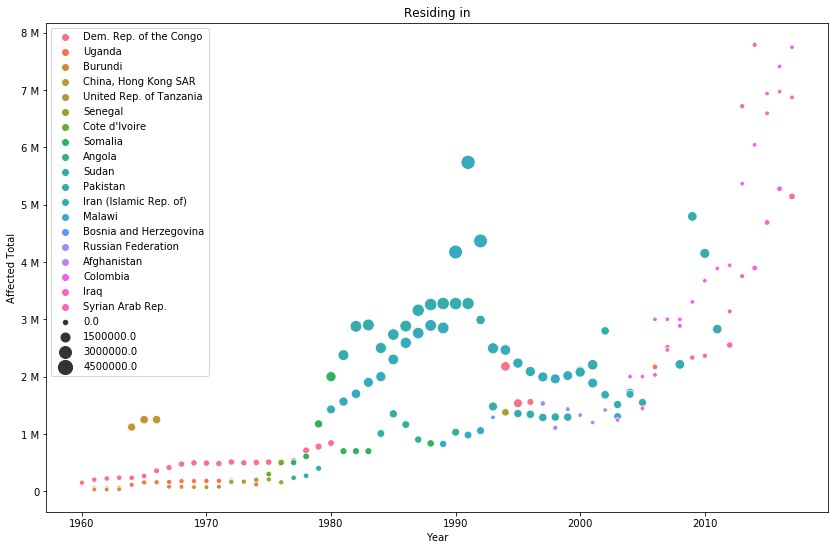

In [117]:
plt.figure(figsize=(14,9))
ax = sns.scatterplot(x=[data['year'] for data in out_residing], 
                     y=[data['affectedTotal'] for data in out_residing], 
                     hue=[data['country'] for data in out_residing],
                     size=[data['affectedRefugees'] for data in out_residing],
                     sizes=(20, 200))
ax.set_title("Residing in")
ax.set_ylabel('Affected Total')
ax.set_xlabel('Year')
ax.yaxis.set_major_formatter(ticker.EngFormatter())

 - Originating from:

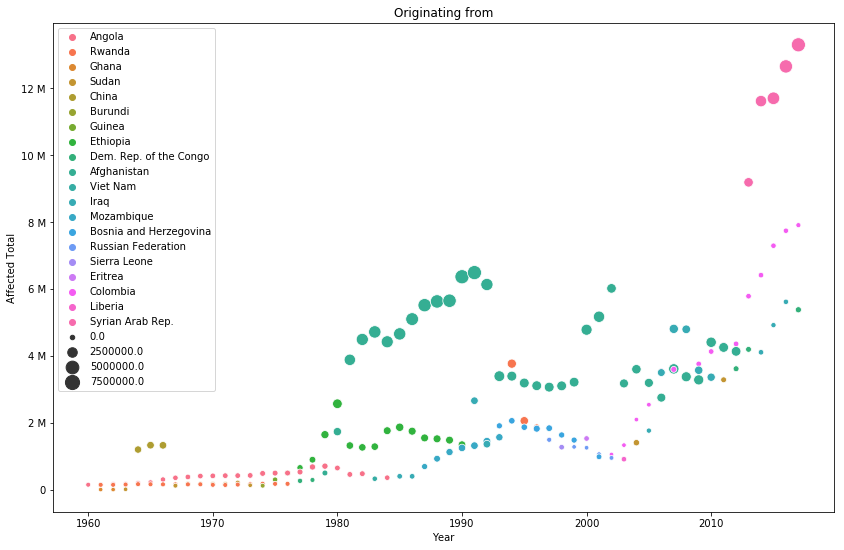

In [116]:
plt.figure(figsize=(14,9))
ax = sns.scatterplot(x=[data['year'] for data in out_originating], 
                     y=[data['affectedTotal'] for data in out_originating], 
                     hue=[data['country'] for data in out_originating],
                     size=[data['affectedRefugees'] for data in out_originating],
                     sizes=(20, 200))
ax.set_title("Originating from")
ax.set_ylabel('Affected Total')
ax.set_xlabel('Year')
ax.yaxis.set_major_formatter(ticker.EngFormatter())

### Analyse refugees and asylum seekes figures for one particular country in a given a given year

 - Given year and country of residence, obtain the number of people that request asylum and their country of origin:

In [171]:
def origin_countries_given_residence_and_year(tx,year,country_residence):
    return tx.run("MATCH (a:CountryYear)<-[r:RESIDE_IN]-(b:CountryYear) "
                         "WHERE a.year={0} AND a.country={1} " 
                         "RETURN b.country AS country, "                         
                         "r.affected_refugees AS affectedRefugees, "
                         "r.affected_asylum AS affectedAsylum, "
                         "r.affected_total AS affectedTotal "
                         "ORDER BY affectedTotal DESC"
                  .format(year,country_residence))

 - Given year and country of origin, obtain the number of people that request asylum and their country of residence:

In [172]:
def origin_countries_given_origin_and_year(tx,year,country_origin):
    return tx.run("MATCH (a:CountryYear)-[r:RESIDE_IN]->(b:CountryYear) "
                         "WHERE a.year={0} AND a.country={1} " 
                         "RETURN b.country as country, "
                         "r.affected_refugees AS affectedRefugees, "
                         "r.affected_asylum AS affectedAsylum, "
                         "r.affected_total AS affectedTotal "
                         "ORDER BY affectedTotal DESC".format(year,country_origin))

Calling both previous functions and ploting results for a year/country:

In [200]:
country_A2 = '"Spain"'
year_A2 = 2017

In [201]:
with driver.session() as session:
    countries_given_residence = session.read_transaction(origin_countries_given_residence_and_year, year_A2, country_A2).data()
    countries_given_origin = session.read_transaction(origin_countries_given_origin_and_year, year_A2, country_A2).data()

Remove None and turn into 0 for ploting:

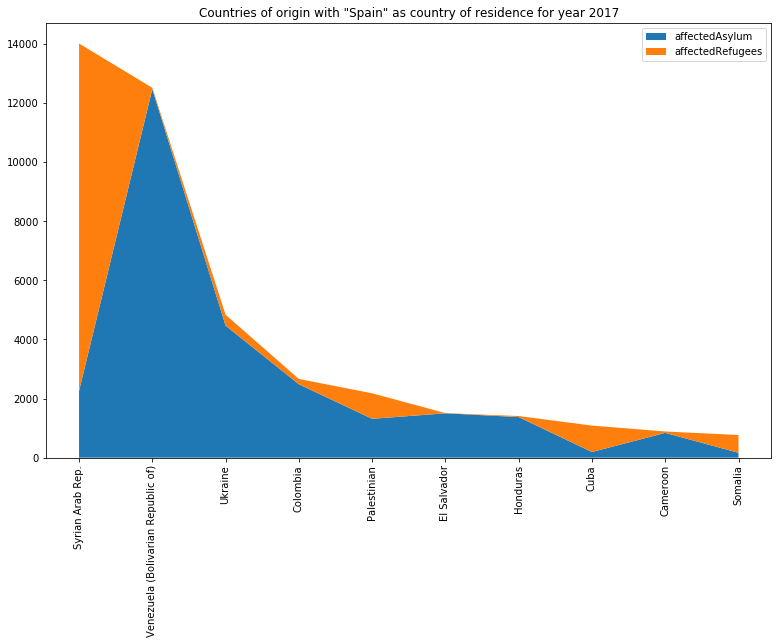

In [216]:
fig, ax = plt.subplots()
fig.set_figheight(8)
fig.set_figwidth(13)
ax.stackplot([data['country'] for data in countries_given_residence][0:10], 
             [int(data['affectedAsylum'] or 0) for data in countries_given_residence][0:10], 
             [int(data['affectedRefugees'] or 0) for data in countries_given_residence][0:10])
plt.xticks(rotation='vertical')
plt.legend(('affectedAsylum', 'affectedRefugees'))
plt.title("Countries of origin with {0} as country of residence for year {1}".format(country_A2, year_A2))
plt.show()

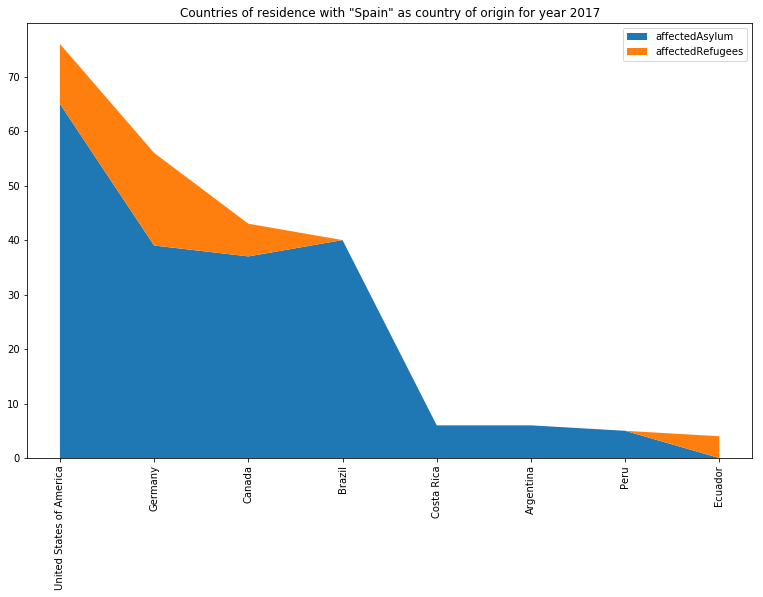

In [217]:
fig, ax = plt.subplots()
fig.set_figheight(8)
fig.set_figwidth(13)
ax.stackplot([data['country'] for data in countries_given_origin][0:10], 
             [int(data['affectedAsylum'] or 0) for data in countries_given_origin][0:10], 
             [int(data['affectedRefugees'] or 0) for data in countries_given_origin][0:10])
plt.xticks(rotation='vertical')
plt.legend(('affectedAsylum', 'affectedRefugees'))
plt.title("Countries of residence with {0} as country of origin for year {1}".format(country_A2, year_A2))
plt.show()

https://matplotlib.org/gallery.html
    
https://seaborn.pydata.org/examples/index.html

https://matplotlib.org/examples/lines_bars_and_markers/barh_demo.html

## Export subgraph

to graphml

In [ ]:
#CALL apoc.export.graphml.query("MATCH p=()<-[r:RESIDE_IN]-(n) WHERE n.country='Spain' AND n.year=2017 RETURN p","./data/prueba.graphml",{})

to json